# Final Proj

## Initial Scripts

In [2]:
import os
import subprocess
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from itertools import combinations
import pandas as pd
import sys
import matplotlib.pyplot as plt
import time
from itertools import combinations

### Scoring

In [3]:
def reorder_alignment(reference, test):
    """
    Reorder the test alignment to match the order of the reference alignment by sequence IDs.
    """
    ref_ids = [record.id for record in reference]
    test_dict = {record.id: record for record in test}

    # Ensure all IDs in the reference are present in the test
    if not all(ref_id in test_dict for ref_id in ref_ids):
        missing = [ref_id for ref_id in ref_ids if ref_id not in test_dict]
        print(f"Error: Missing sequences in test alignment: {', '.join(missing)}")
        sys.exit(1)

    # Reorder test alignment to match reference
    reordered_test = MultipleSeqAlignment([test_dict[ref_id] for ref_id in ref_ids])
    return reordered_test

def calculate_sp_score(reference, test):
    """
    Calculate Sum-of-Pairs (SP) score for a test alignment given a reference alignment.
    """
    sp_matches = 0
    total_pairs = 0

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        # Generate all pairwise combinations for this column
        ref_pairs = set(combinations(ref_col, 2))
        test_pairs = set(combinations(test_col, 2))

        # Count matching pairs
        sp_matches += len(ref_pairs & test_pairs)
        total_pairs += len(ref_pairs)

    sp_score = sp_matches / total_pairs if total_pairs > 0 else 0
    return sp_score

def calculate_tc_score(reference, test):
    """
    Calculate Total Column (TC) score for a test alignment given a reference alignment.
    """
    column_matches = 0

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        if ref_col == test_col:
            column_matches += 1

    tc_score = column_matches / num_columns if num_columns > 0 else 0
    return tc_score

def score_files(ref_file, test_file, format):
    # Load the alignments
    reference = AlignIO.read(ref_file, "msf")
    test = AlignIO.read(test_file, format)

    # Ensure the alignments are loaded as MultipleSeqAlignment objects
    if not isinstance(reference, MultipleSeqAlignment) or not isinstance(test, MultipleSeqAlignment):
        print("Error: Failed to parse the alignments as MultipleSeqAlignment objects.")
        sys.exit(1)

    # Reorder the test alignment to match the reference
    reordered_test = reorder_alignment(reference, test)

    # Calculate scores
    sp_score = calculate_sp_score(reference, reordered_test)
    tc_score = calculate_tc_score(reference, reordered_test)

    # Output results
    return {"SP": sp_score, "TC": tc_score}

# Function to run bali_score
def run_bali_score(reference_msf, test_alignment, score_output):
    print(reference_msf)
    score = score_files(reference_msf, test_alignment, "fasta")
    print(score)
    with open(score_output, 'w') as f_out:
        f_out.write(str(score))
    return score

### Benchmarks

In [ ]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'

# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]

# Alignment tools with direct command-line calls
alignment_tools = {
    'mafft': {
        'command': lambda input_file, output_file: f"mafft --auto --inputorder {input_file} > {output_file}",
        'output_ext': '_mafft_aligned.fasta'
    },
    'muscle': {
        'command': lambda input_file, output_file: f"muscle -in {input_file} -out {output_file}",
        'output_ext': '_muscle_aligned.fasta'
    },
    'clustalw': {
        'command': lambda input_file, output_file: f"clustalw -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA",
        'output_ext': '_clustalw_aligned.fasta'
    }
}

def get_original_ids(tfa_file):
    original_ids = []
    for record in SeqIO.parse(tfa_file, 'fasta'):
        original_ids.append(record.id)
    return original_ids

def sort_alignment(input_alignment_file, output_alignment_file, file_format, original_ids):
    # Read the alignment
    alignment = AlignIO.read(input_alignment_file, file_format)

    # Create a dictionary of records with IDs as keys
    record_dict = {record.id: record for record in alignment}

    # Reorder the records based on original IDs
    sorted_records = []
    for oid in original_ids:
        if oid in record_dict:
            record = record_dict[oid]
            # Ensure the record ID matches the original ID exactly
            record.id = oid
            sorted_records.append(record)
        else:
            print(f"Warning: ID {oid} not found in alignment.")
            return None  # Alignment IDs don't match

    # Create a new MultipleSeqAlignment object
    sorted_alignment = MultipleSeqAlignment(sorted_records)

    # Write the sorted alignment to a file
    AlignIO.write(sorted_alignment, output_alignment_file, file_format)

    return sorted_alignment

# Main benchmarking loop
results = []

for test_case in test_cases:
    tfa_file = os.path.join(file_path, f'{test_case}.tfa')
    msf_file = os.path.join(file_path, f'{test_case}.msf')

    # Check if files exist
    if not os.path.exists(tfa_file) or not os.path.exists(msf_file):
        print(f'Files for {test_case} not found.')
        continue

    # Get original sequence IDs
    original_ids = get_original_ids(tfa_file)

    for tool_name, tool_info in alignment_tools.items():
        output_file = os.path.join(f'{file_path}/results', f'{test_case}{tool_info["output_ext"]}')
        # sorted_output_file = os.path.join(f'{file_path}/results', f'{test_case}_{tool_name}_sorted.msf')
        score_output = os.path.join(f'{file_path}/results', f'{test_case}_{tool_name}_score.txt')

        print(f'Running {tool_name} on {test_case}...')

        # Construct the command
        command = tool_info['command'](tfa_file, output_file)
        print(f'Executing command: {command}')

        start = time.time()
        # Run the alignment tool
        process = subprocess.run(command, shell=True, capture_output=True, text=True)
        end = time.time()

        # Check for errors
        if process.returncode != 0:
            print(f"Error running {tool_name} on {test_case}:")
            print(process.stderr)
            continue

        # Sort the alignment
        # sorted_alignment = sort_alignment(output_file, sorted_output_file, 'fasta', original_ids)

        # if sorted_alignment is None:
        #     print(f"Error sorting alignment for {test_case} with {tool_name}.")
        #     continue
        
        # # Convert the sorted FASTA alignment to MSF using seqret (part of EMBOSS)
        # msf_output_file = sorted_output_file.replace("_sorted.fasta", "_sorted.msf")
        # seqret_command = f"seqret -sequence {sorted_output_file} -outseq {msf_output_file} -osformat2 msf"
        
        # seqret_process = subprocess.run(seqret_command, shell=True, capture_output=True, text=True)
        # if seqret_process.returncode != 0:
        #     print("Error converting to MSF format:")
        #     print(seqret_process.stderr)
        #     continue

        # Now run bali_score using the MSF file if needed, or continue using the FASTA file
        # This depends on what format bali_score expects. If bali_score can handle FASTA directly, use sorted_output_file.
        # If it requires MSF, use msf_output_file instead:
        # process = run_bali_score(xml_file, sorted_output_file, score_output)
        # If you want to use MSF instead:
        score = run_bali_score(msf_file, output_file, score_output)

        print('score', score)
        
        # Append to results
        results.append({
            'test_case': test_case,
            'tool': tool_name,
            'TC': score['TC'],
            'SP': score['SP'],
            'time': end - start
        })

        print(f'Results for {tool_name} on {test_case}:')
        print(score)
        print('---')

# Display results in a DataFrame
df = pd.DataFrame(results)

Running mafft on BB11031...
Executing command: mafft --auto --inputorder bb3_release/RV11/BB11031.tfa > bb3_release/RV11/results/BB11031_mafft_aligned.fasta
Error running mafft on BB11031:
/bin/sh: mafft: command not found

Running muscle on BB11031...
Executing command: muscle -in bb3_release/RV11/BB11031.tfa -out bb3_release/RV11/results/BB11031_muscle_aligned.fasta
bb3_release/RV11/BB11031.msf
{'SP': 0.08151774785801713, 'TC': 0.0028208744710860366}
score {'SP': 0.08151774785801713, 'TC': 0.0028208744710860366}
Results for muscle on BB11031:
{'SP': 0.08151774785801713, 'TC': 0.0028208744710860366}
---
Running clustalw on BB11031...
Executing command: clustalw -INFILE=bb3_release/RV11/BB11031.tfa -OUTFILE=bb3_release/RV11/results/BB11031_clustalw_aligned.fasta -OUTPUT=FASTA
bb3_release/RV11/BB11031.msf
{'SP': 0.11699415029248537, 'TC': 0.07528641571194762}
score {'SP': 0.11699415029248537, 'TC': 0.07528641571194762}
Results for clustalw on BB11031:
{'SP': 0.11699415029248537, 'TC': 0

KeyboardInterrupt: 

Average scores per tool:
                TC        SP      time
tool                                  
clustalw  0.115838  0.198547  0.100427
mafft     0.096898  0.176660  1.087035
muscle    0.121346  0.206147  0.145221


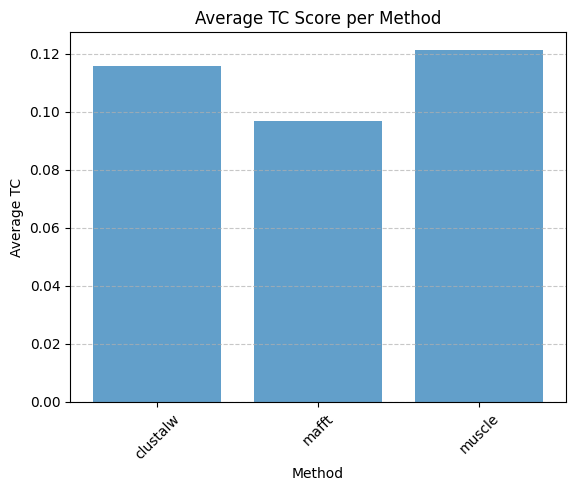

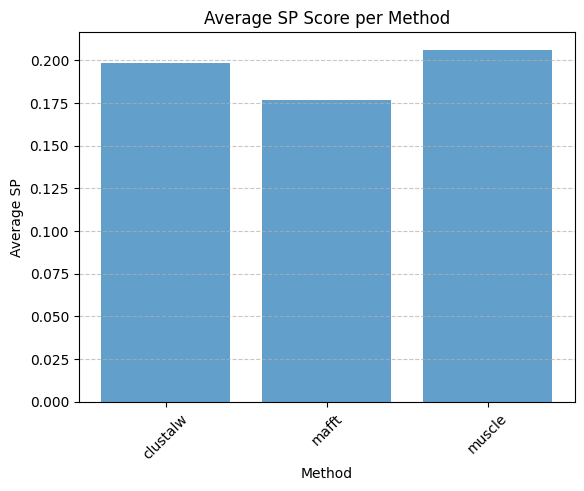

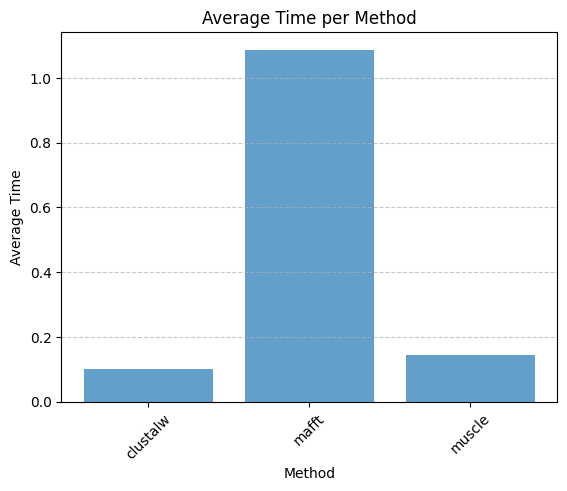

In [26]:
# Calculate the average scores per tool
averages = df.groupby('tool')[['TC', 'SP', 'time']].mean()
print("Average scores per tool:")
print(averages)

# Plot histograms for TC and SP scores
for score in ['TC', 'SP']:
    plt.figure()
    plt.bar(averages.index, averages[score], alpha=0.7)
    plt.title(f'Average {score} Score per Method')
    plt.xlabel('Method')
    plt.ylabel(f'Average {score}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plt.figure()
plt.bar(averages.index, averages['time'], alpha=0.7)
plt.title(f'Average Time per Method')
plt.xlabel('Method')
plt.ylabel(f'Average Time')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### PHMM vs PyHMMER

In [73]:
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import AlignIO
import math
from collections import defaultdict

def load_msf_sequences(file_path):
    alignment = AlignIO.read(file_path, "msf")
    sequences = {record.id: str(record.seq) for record in alignment}
    # Check that all sequences have the same length
    lengths = {len(seq) for seq in sequences.values()}
    if len(lengths) != 1:
        raise ValueError("All sequences must have same length in the MSA.")
    return sequences

class ProfileHMM:
    def __init__(self, pseudocount=0.1):
        self.pseudocount = pseudocount
        self.M = 0  # number of match states
        self.alphabet = []
        # Emission probabilities for match and insert states:
        # match_emission[i][char] = emission prob of char at M_i
        # insert_emission[i][char] = emission prob of char at I_i
        self.match_emission = []
        self.insert_emission = []
        
        # Transition probabilities:
        # We'll store transitions in a dict of dicts:
        # transitions[(state_type, i)][(next_state_type, j)] = probability
        # state_type in { 'S', 'M', 'I', 'D', 'E' }
        # i in range 0..M for I states, 1..M for M and D states
        # S and E have no i-index
        self.transitions = {}
        
        # State indexing:
        # S: start
        # M_i: match state for column i (1-based)
        # I_i: insert state associated with column i (0-based for i=0..M)
        # D_i: delete state associated with column i (1-based)
        # E: end
        #
        # The topology:
        # S -> M_1, I_0
        # M_i -> M_(i+1), I_i, D_(i+1)
        # I_i -> I_i, M_(i+1)
        # D_i -> D_(i+1), I_i, M_(i+1)
        # M_M, I_M, D_M -> E

    def train(self, aligned_sequences):
        """
        Train the profile HMM from a given MSA.
        All sequences have same length = M, so we have M match states.
        We'll treat all columns as match states.
        """
        if not aligned_sequences:
            raise ValueError("No sequences provided for training")
        
        seqs = list(aligned_sequences.values())
        N = len(seqs)
        self.M = len(seqs[0])

        # Determine alphabet
        all_chars = set("".join(seqs))
        if '-' in all_chars:
            all_chars.remove('-')
        self.alphabet = list(all_chars)

        # Count emissions:
        # For match states (M_i): count only chars aligned at column i (no gap)
        # For insert states (I_i): In a strict alignment, insert states represent unaligned chars between columns.
        # Without additional info, we can approximate insert emissions as uniform or minimal. 
        # A more realistic approach requires heuristics (e.g., no insertions in training MSA).
        # For simplicity, we will assume no observed inserts from the MSA (no extra unaligned chars).
        # We'll just set insert emissions to uniform distribution with pseudocount.

        match_counts = [defaultdict(int) for _ in range(self.M)]
        
        # Transition counts
        # We'll store transitions as counts:
        # Key: (prev_state_type, prev_i), Value: defaultdict(int) for next states
        # For example: ('M', i) -> {('M', i+1): count, ('I', i): count, ('D', i+1): count}
        transition_counts = defaultdict(lambda: defaultdict(int))

        # In a standard MSA, each column is either a match or a gap for each sequence.
        # Paths:
        # Start at S.
        # For i in 1..M:
        #   If seq has char at column i (not '-'), we are in M_i state.
        #   If seq has '-' at column i, we are in D_i state.
        # After finishing M columns, go to E.

        for seq in seqs:
            prev_state = ('S', 0)  # start
            for i, char in enumerate(seq, start=1):
                if char == '-':
                    # go to D_i
                    transition_counts[prev_state][('D', i)] += 1
                    prev_state = ('D', i)
                else:
                    # go to M_i
                    transition_counts[prev_state][('M', i)] += 1
                    match_counts[i-1][char] += 1
                    prev_state = ('M', i)
            
            # After last column go to E
            transition_counts[prev_state][('E', 0)] += 1

        # Insert states:
        # We have I_0...I_M, but in a strict MSA with no unaligned insertions, 
        # we have no direct evidence of insert emissions. We'll assume uniform emissions.
        # This is a simplification. In practical scenarios, you might detect insertions from gaps patterns.
        
        # Emission probabilities for match states:
        self.match_emission = []
        for i in range(self.M):
            counts = match_counts[i]
            total = sum(counts.values()) + len(self.alphabet)*self.pseudocount
            emis = {a: (counts.get(a,0)+self.pseudocount)/total for a in self.alphabet}
            self.match_emission.append(emis)

        # Insert emissions: uniform
        self.insert_emission = []
        for i in range(self.M+1):
            total = len(self.alphabet)*self.pseudocount
            emis = {a: self.pseudocount/total for a in self.alphabet}
            self.insert_emission.append(emis)

        # Normalize transitions
        def normalize(counts):
            total = sum(counts.values()) + self.pseudocount*len(counts)
            return {k: (v+self.pseudocount)/total for k,v in counts.items()}

        # Convert transition counts to probabilities
        # We must ensure all possible transitions are included with pseudocounts.
        # For simplicity, we will only normalize over the observed transitions. 
        # In a more complete implementation, you'd ensure all theoretically possible transitions have at least pseudocount.

        self.transitions = {}
        for prev_state, next_dict in transition_counts.items():
            self.transitions[prev_state] = normalize(next_dict)

        # Ensure that all states have defined transitions.
        # Define a helper function to get transitions or default:
        def get_trans(prev, nxt):
            return self.transitions.get(prev, {}).get(nxt, self.pseudocount)  # fallback pseudocount

        # We now have a trained pHMM.

    def viterbi_align(self, sequence):
        """
        Align a sequence of arbitrary length to the profile HMM using the Viterbi algorithm.
        The DP matrix will have dimensions: (Number_of_states) x (len(sequence)+1)

        States: S, M_1..M_M, I_0..I_M, D_1..D_M, E
        We'll store them in a list for indexing.
        For simplicity, we map states to a linear array and store transitions in a dictionary keyed by these tuples.
        """

        seq = sequence
        n = len(seq)

        # Build a state list for DP:
        # Order of states (a standard order): S, I_0, M_1, I_1, D_1, M_2, I_2, D_2, ... M_M, I_M, D_M, E
        # We'll store them in a list to index them:
        state_list = [('S',0), ('I',0)]
        for i in range(1, self.M+1):
            state_list.append(('M',i))
            state_list.append(('I',i))
            state_list.append(('D',i))
        state_list.append(('E',0))
        
        # Create mappings for index:
        state_index = {s:i for i,s in enumerate(state_list)}

        # Viterbi matrices:
        # v[i][j] = best log probability of aligning seq[:j] (j chars) to the model up to state i
        # traceback to store the best previous state
        v = [[-math.inf]*(n+1) for _ in range(len(state_list))]
        traceback = [[None]*(n+1) for _ in range(len(state_list))]

        # Emission function:
        def emission_prob(state, char):
            stype, idx = state
            if stype == 'M':
                # Match state emits char
                if char not in self.match_emission[idx-1]:
                    return math.log(self.pseudocount/ (len(self.alphabet)*self.pseudocount))
                return math.log(self.match_emission[idx-1][char])
            elif stype == 'I':
                # Insert state
                return math.log(self.insert_emission[idx][char])
            elif stype == 'D':
                # Delete state emits nothing, no emission probability when advancing in sequence from D.
                # If we stay in the same seq position (no char consumed), no emission. So no emission cost.
                return 0.0
            else:
                # S and E do not emit
                return 0.0

        # Initialization:
        # At j=0 (no sequence chars consumed), we start from S:
        v[state_index[('S',0)]][0] = 0.0  # log(1)
        
        # To handle transitions correctly, we must consider transitions that do not consume a character (D-states) and transitions that do.
        # When we enter a match or insert state, we consume one character of the sequence.
        # When we enter a delete or start/end states, we do not consume a character.

        # Distinguish transitions that consume a character (M,I) vs those that don't (D,S,E).
        def state_consumes_char(st):
            stype, _ = st
            return (stype == 'M' or stype == 'I')

        # We will do a nested loop:
        # Outer loop over j=0..n (position in sequence)
        # Inner loop over states to fill v[i][j].
        # We'll do until no changes occur or we fill the table completely.

        for j in range(n+1):
            for i, state in enumerate(state_list):
                if v[i][j] == -math.inf:
                    continue
                # Current score
                curr_score = v[i][j]
                # Possible next states:
                # get transitions from this state:
                next_trans = self.transitions.get(state, {})
                for nxt_state, tprob in next_trans.items():
                    nxt_i = state_index[nxt_state]
                    if state_consumes_char(nxt_state):
                        # consume one char if available
                        if j < n:
                            char = seq[j]
                            score = curr_score + math.log(tprob) + emission_prob(nxt_state, char)
                            # Goes to v[nxt_i][j+1]
                            if score > v[nxt_i][j+1]:
                                v[nxt_i][j+1] = score
                                traceback[nxt_i][j+1] = (i, j)
                    else:
                        # no char consumed
                        score = curr_score + math.log(tprob)
                        # Goes to v[nxt_i][j]
                        if score > v[nxt_i][j]:
                            v[nxt_i][j] = score
                            traceback[nxt_i][j] = (i, j)

        # Find best score in end state (E,0) with j=n
        end_idx = state_index[('E',0)]
        best_score = v[end_idx][n]
        if best_score == -math.inf:
            # no alignment found
            aligned_seq = "-"*n
            return aligned_seq

        # Traceback:
        # We find the path that led to (E,0) at j=n
        align_states = []
        ci, cj = end_idx, n
        while not (ci == state_index[('S',0)] and cj == 0):
            align_states.append((state_list[ci], cj))
            (pi, pj) = traceback[ci][cj]
            ci, cj = pi, pj
        align_states.reverse()

        # align_states now contains the path of states and the j positions in the sequence.
        # Construct the aligned sequence:
        # When in M or I state: we consumed one character of the sequence at that step.
        # When in D or S or E state: we did not consume a character.
        # The alignment can be reconstructed by aligning the model states to the sequence characters.
        # For simplicity, we will just reconstruct a sequence with gaps ('-') where delete states were used.
        # In a full MSA context, you'd also map which columns correspond to which match states, etc.

        # Extract aligned sequence:
        # We'll keep track of how many chars we have consumed at each step.
        aligned_chars = []
        seq_pos = 0
        for k in range(1, len(align_states)):
            # alignment step from align_states[k-1] to align_states[k]
            state, jpos = align_states[k]
            # If state consumes char, we used seq[jpos-1] (since jpos is 1-based in code)
            # Actually jpos in code was used as indexing from 1, but we were consistent above with Python indexing from 0.
            # We need to be careful: we used v[i][j], j from 0..n. When we consume a char, we move from j to j+1.
            # The character consumed at that step is seq[jpos-1].
            if state[0] in ['M','I']: 
                aligned_chars.append(seq[jpos-1])
            elif state[0] == 'D':
                aligned_chars.append('-')

        # aligned_chars now is the sequence as aligned through the model path
        # Note that this alignment is relative to the profile model columns. 
        # To produce a meaningful alignment to other sequences, you'd output all aligned sequences with respect to the match states. 
        # Here, we just return the aligned representation.

        return ''.join(aligned_chars)

    def align_sequences(self, sequences, output_file=None):
        """
        Align sequences to the HMM using the Viterbi algorithm and output formatted alignments.
        Args:
            sequences (dict): A dictionary of sequences {id: sequence}.
            output_file (str): Path to write the alignment in FASTA format.
        """
        def format_sequence(seq, block_size=60):
            """Format sequence into blocks of fixed size for cleaner output."""
            return "\n".join([seq[i:i+block_size] for i in range(0, len(seq), block_size)])

        aligned_records = []
        for name, seq in sequences.items():
            aligned_seq = self.viterbi_align(seq)
            aligned_records.append((name, aligned_seq))  # Correctly store name and aligned sequence

        # Write to output file if specified
        if output_file:
            with open(output_file, "w") as out_f:
                for name, aligned_seq in aligned_records:
                    formatted_seq = format_sequence(aligned_seq)  # Format sequence into blocks
                    out_f.write(f">{name}\n{formatted_seq}\n")  # Write FASTA format
            print(f"Alignment written to {output_file}")
        
        # Return aligned records as a list of tuples
        return aligned_records


##### alphabet impl

In [71]:
#Implementation 1: has too high of an accuracy

class ProfileHMM:
    def __init__(self, pseudocount=0.1):
        """
        Initialize the Profile HMM.
        """
        self.pseudocount = pseudocount
        self.M = 0  # Number of match states
        self.alphabet = []  # Character set from sequences
        self.match_emission = []  # Match state emissions
        self.insert_emission = []  # Insert state emissions
        self.transitions = {}  # Transition probabilities

    def train(self, aligned_sequences):
        """
        Train the profile HMM using a given MSA.
        """
        if not aligned_sequences:
            raise ValueError("No sequences provided for training.")

        seqs = list(aligned_sequences.values())
        self.M = len(seqs[0])  # Length of alignment
        self.alphabet = list({char for seq in seqs for char in seq if char != '-'})

        # Count emissions and transitions
        match_counts = [defaultdict(int) for _ in range(self.M)]
        transition_counts = defaultdict(lambda: defaultdict(int))


        for seq in seqs:
            prev_state = ('S', 0)  # Start state
            for i, char in enumerate(seq, start=1):
                if char == '-':
                    transition_counts[prev_state][('D', i)] += 1
                    prev_state = ('D', i)
                else:
                    transition_counts[prev_state][('M', i)] += 1
                    match_counts[i - 1][char] += 1
                    prev_state = ('M', i)
            transition_counts[prev_state][('E', 0)] += 1  # End state

        # Calculate emissions
        self.match_emission = [
            {a: (match_counts[i].get(a, 0) + self.pseudocount) /
                (sum(match_counts[i].values()) + len(self.alphabet) * self.pseudocount)
             for a in self.alphabet}
            for i in range(self.M)
        ]

        self.insert_emission = [
            {a: self.pseudocount / (len(self.alphabet) * self.pseudocount)
             for a in self.alphabet}
            for _ in range(self.M + 1)
        ]

        # Normalize transitions
        self.transitions = {
            prev: {nxt: (count + self.pseudocount) /
                   (sum(next_counts.values()) + len(next_counts) * self.pseudocount)
                   for nxt, count in next_counts.items()}
            for prev, next_counts in transition_counts.items()
        }

    def viterbi_align(self, sequence):
        """
        Align a sequence to the profile HMM using the Viterbi algorithm.
        """
        n = len(sequence)
        state_list = [('S', 0), ('I', 0)] + \
                     [(t, i) for i in range(1, self.M + 1) for t in ('M', 'I', 'D')] + \
                     [('E', 0)]
        state_index = {s: idx for idx, s in enumerate(state_list)}

        v = [[-math.inf] * (n + 1) for _ in range(len(state_list))]
        traceback = [[None] * (n + 1) for _ in range(len(state_list))]

        v[state_index[('S', 0)]][0] = 0.0

        def emission_prob(state, char):
            stype, idx = state
            if stype == 'M':
                return math.log(self.match_emission[idx - 1].get(char, self.pseudocount))
            if stype == 'I':
                return math.log(self.insert_emission[idx].get(char, self.pseudocount))
            return 0.0

        for j in range(n + 1):
            for i, state in enumerate(state_list):
                if v[i][j] == -math.inf:
                    continue
                curr_score = v[i][j]
                for nxt_state, tprob in self.transitions.get(state, {}).items():
                    nxt_i = state_index[nxt_state]
                    if nxt_state[0] in {'M', 'I'} and j < n:
                        char = sequence[j]
                        score = curr_score + math.log(tprob) + emission_prob(nxt_state, char)
                        if score > v[nxt_i][j + 1]:
                            v[nxt_i][j + 1] = score
                            traceback[nxt_i][j + 1] = (i, j)
                    elif nxt_state[0] in {'D', 'E'}:
                        score = curr_score + math.log(tprob)
                        if score > v[nxt_i][j]:
                            v[nxt_i][j] = score
                            traceback[nxt_i][j] = (i, j)

        aligned_seq = []
        best_score = v[state_index[('E', 0)]][n]
        if best_score == -math.inf:
            return '-' * n

        ci, cj = state_index[('E', 0)], n
        while ci != state_index[('S', 0)] or cj != 0:
            state, jpos = state_list[ci], cj
            if state[0] in {'M', 'I'}:
                aligned_seq.append(sequence[jpos - 1])
            elif state[0] == 'D':
                aligned_seq.append('-')
            ci, cj = traceback[ci][cj]

        return ''.join(reversed(aligned_seq))

    def align_sequences(self, sequences, output_file=None):
        """
        Align multiple sequences to the profile HMM.
        """
        aligned_records = [
            (name, self.viterbi_align(seq)) for name, seq in sequences.items()
        ]
        if output_file:
            with open(output_file, "w") as f:
                for name, aligned_seq in aligned_records:
                    f.write(f">{name}\n{aligned_seq}\n")
        return aligned_records


##### Krogh paper

In [59]:
import math
from collections import defaultdict

class ProfileHMM:
    def __init__(self, pseudocount=1.0):
        self.pseudocount = pseudocount
        # Fix the alphabet to the 20 standard amino acids
        self.alphabet = list("ACDEFGHIKLMNPQRSTVWY")
        self.M = 0
        self.states = []
        self.state_index = {}
        self.emission_prob = {}
        self.transitions = {}

    def _build_model_structure(self):
        # States: B, M_i, I_i, D_i for i=1..M, plus I_0 and E
        self.states = [('B',0)] \
                      + [('M',i) for i in range(1,self.M+1)] \
                      + [('I',i) for i in range(0,self.M+1)] \
                      + [('D',i) for i in range(1,self.M+1)] \
                      + [('E',0)]

        self.state_index = {s: idx for idx, s in enumerate(self.states)}
        for s in self.states:
            self.transitions[s] = {}

    def _identify_match_columns(self, aligned_seqs, gap_threshold=0.5):
        seqs = list(aligned_seqs.values())
        L = len(seqs[0])
        num_seqs = len(seqs)
        
        match_cols = []
        for i in range(L):
            gaps = sum(seq[i] == '-' for seq in seqs)
            if gaps / num_seqs < gap_threshold:
                match_cols.append(True)
            else:
                match_cols.append(False)
        return match_cols

    def train(self, aligned_sequences, max_iterations=10, gap_threshold=0.5):
        if not aligned_sequences:
            raise ValueError("No sequences provided for training.")
        seqs = list(aligned_sequences.values())
        length = len(seqs[0])
        for s in seqs:
            if len(s) != length:
                raise ValueError("All sequences must be aligned and same length.")

        # Identify match states
        match_mask = self._identify_match_columns(aligned_sequences, gap_threshold=gap_threshold)
        self.M = sum(match_mask)

        self._build_model_structure()

        # Map alignment columns to match indices
        match_index = []
        c = 1
        for is_match in match_mask:
            if is_match:
                match_index.append(c)
                c += 1
            else:
                match_index.append(None)

        # Count transitions/emissions from MSA
        transition_counts = defaultdict(lambda: defaultdict(float))
        emission_counts = defaultdict(lambda: defaultdict(float))

        for seq in seqs:
            path_states = self._sequence_to_path(seq, match_index)
            prev = ('B',0)
            for (state, char) in path_states:
                transition_counts[prev][state] += 1.0
                if state[0] in ('M','I') and char in self.alphabet:
                    emission_counts[state][char] += 1.0
                prev = state
            transition_counts[prev][('E',0)] += 1.0

        # Initialize insert states: uniform distribution over alphabet
        for s in self.states:
            if s[0] == 'I':
                for a in self.alphabet:
                    emission_counts[s][a] += self.pseudocount

        # Convert counts to initial probabilities
        self._normalize_transitions(transition_counts)
        self._normalize_emissions(emission_counts)

        # Baum-Welch EM re-estimation
        for _ in range(max_iterations):
            expected_trans, expected_emit = self._forward_backward(seqs, match_index)
            self._normalize_transitions(expected_trans)
            self._normalize_emissions(expected_emit)

    def _sequence_to_path(self, seq, match_index):
        # Convert an aligned sequence to a rough path
        path = []
        prev_match = 0
        for i, char in enumerate(seq):
            mi = match_index[i]
            if mi is not None:
                # Match column
                if char == '-':
                    path.append((('D', mi), char))
                else:
                    path.append((('M', mi), char))
                prev_match = mi
            else:
                # Insert column
                if char == '-':
                    # Gap in an insert region -> treat as deletion relative to next match
                    next_match = prev_match+1 if prev_match < self.M else self.M
                    path.append((('D', next_match), '-'))
                else:
                    # Insert state between matches
                    path.append((('I', prev_match), char))
        return path

    def _normalize_transitions(self, transition_counts):
        for s in self.states:
            next_counts = transition_counts[s]
            if not next_counts:
                continue
            total = sum(next_counts.values()) + self.pseudocount*len(next_counts)
            self.transitions[s] = {}
            for nxt in next_counts:
                self.transitions[s][nxt] = (next_counts[nxt] + self.pseudocount) / total

    def _normalize_emissions(self, emission_counts):
        for s in self.states:
            if s[0] in ('M','I'):
                next_counts = emission_counts[s]
                total = sum(next_counts.values()) + self.pseudocount*len(self.alphabet)
                self.emission_prob[s] = {}
                for a in self.alphabet:
                    self.emission_prob[s][a] = (next_counts[a] + self.pseudocount) / total
            else:
                self.emission_prob[s] = {}

    def _forward_backward(self, seqs, match_index):
        expected_trans = defaultdict(lambda: defaultdict(float))
        expected_emit = defaultdict(lambda: defaultdict(float))

        # NOTE: For large datasets, implement scaling for forward/backward
        for seq in seqs:
            fwd = self._forward(seq)
            bwd = self._backward(seq)

            # Compute posteriors (simple approximation, not fully scaled)
            # Posterior(s,t) ~ fwd[t][s]*bwd[t][s]
            # Posterior(trans) similarly computed
            T = len(seq)
            # Compute total probability of seq
            prob_seq = 0.0
            for s, val in fwd[T].items():
                if s == ('E',0):
                    prob_seq += val
            if prob_seq <= 0:
                continue

            for t in range(T+1):
                for s in fwd[t]:
                    fs = fwd[t][s]
                    if fs == 0: continue
                    for nxt, p_tr in self.transitions[s].items():
                        val = fs * p_tr
                        emit_char = None
                        if nxt[0] in ('M','I') and t < T and seq[t] in self.alphabet:
                            eprob = self.emission_prob[nxt].get(seq[t], self.pseudocount/(20*self.pseudocount))
                            val *= eprob * bwd[t+1].get(nxt,0)
                            emit_char = seq[t]
                        elif nxt[0] == 'D':
                            # D does not emit
                            val *= bwd[t].get(nxt,0)
                        elif nxt[0] == 'E' and t == T:
                            val *= bwd[t].get(nxt,0)
                        else:
                            # If there's a mismatch in indexing for backward states, careful debugging needed.
                            continue

                        if val > 0:
                            val /= prob_seq  # normalize
                            expected_trans[s][nxt] += val
                            if emit_char:
                                expected_emit[nxt][emit_char] += val

        return expected_trans, expected_emit

    def _forward(self, seq):
        T = len(seq)
        fwd = [defaultdict(float) for _ in range(T+1)]
        fwd[0][('B',0)] = 1.0

        for t in range(T+1):
            # Temporary accumulators for updates
            same_t_updates = defaultdict(float)   # for D states and possibly E at t==T
            next_t_updates = defaultdict(float)   # for M/I states that consume a character

            for s, fs in fwd[t].items():
                if fs == 0:
                    continue
                for nxt, p_tr in self.transitions[s].items():
                    if nxt[0] in ('M','I') and t < T and seq[t] in self.alphabet:
                        # Emitting state consumes seq[t]
                        eprob = self.emission_prob[nxt].get(seq[t], self.pseudocount/(20*self.pseudocount))
                        val = fs * p_tr * eprob
                        next_t_updates[nxt] += val
                    elif nxt[0] == 'D':
                        # D state: no character consumed, stay at time t
                        val = fs * p_tr
                        same_t_updates[nxt] += val
                    elif nxt[0] == 'E' and t == T:
                        # E state at the end
                        val = fs * p_tr
                        same_t_updates[nxt] += val

            # Now merge updates back:
            # same_t_updates go into fwd[t]
            for st, val in same_t_updates.items():
                fwd[t][st] += val

            # next_t_updates go into fwd[t+1], if t < T
            if t < T:
                for st, val in next_t_updates.items():
                    fwd[t+1][st] += val

        return fwd


    def _backward(self, seq):
        T = len(seq)
        bwd = [defaultdict(float) for _ in range(T+1)]
        bwd[T][('E',0)] = 1.0

        # We go backward in time
        for t in reversed(range(T+1)):
            # Temporary accumulators for updates
            # We'll update bwd[t] or bwd[t-1] after we've processed all states for this timestep
            prev_t_updates = defaultdict(float)  # For transitions that go back to t-1 (M/I states)
            same_t_updates = defaultdict(float)  # For transitions that remain at t (D/E states)
            
            for s, bs in bwd[t].items():
                if bs == 0:
                    continue
                # Find predecessors of s
                for prev in self.states:
                    p_tr = self.transitions[prev].get(s, 0)
                    if p_tr == 0:
                        continue

                    # Check what s is and what it emits
                    if s[0] in ('M','I') and t > 0 and seq[t-1] in self.alphabet:
                        eprob = self.emission_prob[s].get(seq[t-1], self.pseudocount/(20*self.pseudocount))
                        val = bs * p_tr * eprob
                        prev_t_updates[prev] += val

                    elif s[0] == 'D':
                        # D states do not consume a character
                        # So we remain at the same t
                        val = bs * p_tr
                        same_t_updates[prev] += val

                    elif s[0] == 'E' and t == T:
                        # E at the end does not consume char; remains at same t
                        val = bs * p_tr
                        same_t_updates[prev] += val

            # Now merge updates back into bwd arrays
            for st, val in same_t_updates.items():
                bwd[t][st] += val

            for st, val in prev_t_updates.items():
                bwd[t-1][st] += val

        return bwd


    def viterbi_align(self, sequence):
        T = len(sequence)
        V = [defaultdict(lambda: -math.inf) for _ in range(T+1)]
        PTR = [defaultdict(lambda: None) for _ in range(T+1)]

        V[0][('B',0)] = 0.0

        for t in range(T+1):
            # Temporary accumulators
            same_t_updates = defaultdict(lambda: -math.inf)
            next_t_updates = defaultdict(lambda: -math.inf)

            for s, vs in V[t].items():
                if vs == -math.inf:
                    continue
                for nxt, p_tr in self.transitions[s].items():
                    if nxt[0] in ('M','I') and t < T and sequence[t] in self.alphabet:
                        eprob = self.emission_prob[nxt].get(sequence[t], self.pseudocount/(20*self.pseudocount))
                        score = vs + math.log(p_tr) + math.log(eprob)
                        # Goes to t+1
                        if score > next_t_updates[nxt]:
                            next_t_updates[nxt] = score
                            PTR[t+1][nxt] = s
                    elif nxt[0] == 'D':
                        # Stay at same t
                        score = vs + math.log(p_tr)
                        if score > same_t_updates[nxt]:
                            same_t_updates[nxt] = score
                            PTR[t][nxt] = s
                    elif nxt[0] == 'E' and t == T:
                        # End state at t == T
                        score = vs + math.log(p_tr)
                        if score > same_t_updates[nxt]:
                            same_t_updates[nxt] = score
                            PTR[t][nxt] = s

            # Merge updates back
            for st, val in same_t_updates.items():
                if val > V[t][st]:
                    V[t][st] = val

            if t < T:
                for st, val in next_t_updates.items():
                    if val > V[t+1][st]:
                        V[t+1][st] = val

        # Find best path
        best_score = -math.inf
        best_state = None
        for s, val in V[T].items():
            if s == ('E',0) and val > best_score:
                best_score = val
                best_state = s

        aligned = []
        t = T
        curr = best_state
        while not (curr == ('B',0) and t == 0):
            p = PTR[t][curr]
            if curr[0] in ('M','I') and t > 0:
                aligned.append(sequence[t-1])
                t -= 1
            elif curr[0] == 'D':
                aligned.append('-')
            curr = p

        return ''.join(reversed(aligned))


    def align_sequences(self, sequences, output_file=None):
        aligned_records = [
            (name, self.viterbi_align(seq)) for name, seq in sequences.items()
        ]
        if output_file:
            with open(output_file, "w") as f:
                for name, aligned_seq in aligned_records:
                    f.write(f">{name}\n{aligned_seq}\n")
        return aligned_records


#### Comparison

In [62]:
import pyhmmer
import subprocess

def convert_msf_to_fasta(input_msf, output_fasta):
    """
    Convert an MSF alignment file to FASTA format.

    Args:
        input_msf (str): Path to the input MSF file.
        output_fasta (str): Path to the output FASTA file.
    """
    try:
        # Read the MSF file
        alignment = AlignIO.read(input_msf, "msf")
        
        # Write to FASTA format
        AlignIO.write(alignment, output_fasta, "fasta")
        print(f"Conversion successful: '{input_msf}' -> '{output_fasta}'")
    except Exception as e:
        print(f"Error during conversion: {e}")

# Build HMM using pyHMMER
def build_pyhmmer_hmm(fasta_file, hmm_name):
    alphabet = pyhmmer.easel.Alphabet.amino()
    background = pyhmmer.plan7.Background(alphabet)

    with pyhmmer.easel.MSAFile(fasta_file, digital=True, alphabet=alphabet) as msa_file:
        msa = msa_file.read()
        msa.name = hmm_name.encode()
        builder = pyhmmer.plan7.Builder(alphabet)
        hmm, _, _ = builder.build_msa(msa, background)

    with open("profile.hmm", "wb") as hmm_file:
        hmm.write(hmm_file)
    
    return hmm, alphabet, background

# Align sequences using your ProfileHMM
def align_with_profilehmm(profilehmm: ProfileHMM, test_sequences_file, output_file):
    test_alignment = SeqIO.parse(test_sequences_file, "fasta")
    sequences = {record.id: "".join(str(record.seq)) for record in test_alignment}
    aligned_sequences = profilehmm.align_sequences(sequences, output_file)
    
    return aligned_sequences

def align_with_hmmalign(hmm_file, input_fasta, stockholm_output, fasta_output):
    """
    Align sequences to an HMM using hmmalign and convert Stockholm to FASTA.
    Args:
        hmm_file (str): Path to the HMM file.
        input_fasta (str): Path to the unaligned FASTA file.
        stockholm_output (str): Path to save the Stockholm alignment.
        fasta_output (str): Path to save the FASTA alignment.
    """
    try:
        # Run hmmalign
        print("Running hmmalign...")
        subprocess.run(
            ["hmmalign", "--amino", "-o", stockholm_output, hmm_file, input_fasta],
            check=True
        )
        print(f"Stockholm alignment saved to '{stockholm_output}'")

        # Convert Stockholm to FASTA
        print("Converting Stockholm to FASTA...")
        alignment = AlignIO.read(stockholm_output, "stockholm")
        AlignIO.write(alignment, fasta_output, "fasta")
        print(f"FASTA alignment saved to '{fasta_output}'")
    except subprocess.CalledProcessError as e:
        print(f"Error during hmmalign: {e}")
    except Exception as e:
        print(f"Error during conversion to FASTA: {e}")

def convert_to_uppercase(input_fasta, output_fasta):
    """
    Convert all sequences in a FASTA file to uppercase.
    """
    records = []
    for record in SeqIO.parse(input_fasta, "fasta"):
        record.seq = record.seq.upper()
        records.append(record)
    
    SeqIO.write(records, output_fasta, "fasta")
    print(f"Converted sequences written to {output_fasta}")



In [63]:
def train_pHMM(reference_msf):
    # Load reference alignment in MSF format
    reference_alignment = AlignIO.read(reference_msf, "msf")

    # Convert to list of aligned sequences for training
    aligned_sequences = {record.id: "".join(str(record.seq)) for record in reference_alignment}

    # Train your HMM
    hmm = ProfileHMM(pseudocount=.1)
    hmm.train(aligned_sequences)
    return hmm

In [64]:
# Load reference alignment in MSF format
ref_msf = "bb3_release/RV11/BBS11001.msf"  # Example file

hmm = train_pHMM(ref_msf)

In [72]:
# File paths
base_dir = "bb3_release/RV11"
reference_msf = os.path.join(base_dir, "BB11001.msf")
unaligned_fasta = os.path.join(base_dir, "BB11001.tfa")
converted_fasta = os.path.join(base_dir, "BB11001.fasta")

hmm_file = f"profile.hmm"
stockholm_output = f"aligned_sequences.sto"

profilehmm_output = "aligned_profilehmm.fasta"
hmmer_output = "aligned_pyhmmer.fasta"

# Step 1: Convert MSF to FASTA
convert_msf_to_fasta(reference_msf, converted_fasta)

# Step 2: Train ProfileHMM
ref_alignment = AlignIO.read(converted_fasta, "fasta")
sequences = {record.id: "".join(str(record.seq)) for record in ref_alignment}
profilehmm = ProfileHMM()
profilehmm.train(sequences)

# Step 3: Train pyHMMER HMM
hmm, alphabet, background = build_pyhmmer_hmm(converted_fasta, "BB11001")

# Step 4: Align test sequences
# test_sequences = SeqIO.parse(unaligned_fasta, "fasta")
# test_seq_list = ["".join(str(record.seq)) for record in test_sequences]
# print(alp)
align_with_profilehmm(profilehmm, unaligned_fasta, profilehmm_output)

align_with_hmmalign(hmm_file, unaligned_fasta, stockholm_output, hmmer_output)

convert_to_uppercase(hmmer_output, "aligned_pyhmmer.fasta")

# Step 5: Score Alignments
print("\n--- Benchmark Results ---")
profilehmm_scores = score_files(reference_msf, profilehmm_output, "fasta")
pyhmmer_scores = score_files(reference_msf, hmmer_output, "fasta")

print(f"ProfileHMM SP: {profilehmm_scores['SP']:.3f}, TC: {profilehmm_scores['TC']:.3f}")
print(f"pyHMMER SP: {pyhmmer_scores['SP']:.3f}, TC: {pyhmmer_scores['TC']:.3f}")

Conversion successful: 'bb3_release/RV11/BB11001.msf' -> 'bb3_release/RV11/BB11001.fasta'
Running hmmalign...
Stockholm alignment saved to 'aligned_sequences.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'aligned_pyhmmer.fasta'
Converted sequences written to aligned_pyhmmer.fasta

--- Benchmark Results ---
ProfileHMM SP: 1.000, TC: 1.000
pyHMMER SP: 1.000, TC: 1.000


#### Benchmark All RV11

In [69]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'

# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]

results = []

for test_case in test_cases:
    tfa_file = os.path.join(file_path, f'{test_case}.tfa')
    msf_file = os.path.join(file_path, f'{test_case}.msf')
    fasta_file = os.path.join(file_path, f'{test_case}.fasta')
    
    if not os.path.exists(fasta_file):
        print(f'Converting {msf_file} to FASTA format...')
        convert_msf_to_fasta(msf_file, fasta_file)
    
    # Check if files exist
    if not os.path.exists(tfa_file) or not os.path.exists(fasta_file):
        print(f'Files for {test_case} not found.')
        continue
    
    phmm = train_pHMM(msf_file)
    build_pyhmmer_hmm(fasta_file, test_case)
    align_with_profilehmm(phmm, tfa_file, f'{file_path}/{test_case}_profilehmm.fasta')
    align_with_hmmalign(hmm_file, tfa_file, f'{file_path}/{test_case}_hmmer.sto', f'{file_path}/{test_case}_hmmer.fasta')
    convert_to_uppercase(f'{file_path}/{test_case}_hmmer.fasta', f'{file_path}/{test_case}_hmmer.fasta')
    phmm_score = score_files(msf_file, f'{file_path}/{test_case}_profilehmm.fasta', 'fasta')
    hmmer_score = score_files(msf_file, f'{file_path}/{test_case}_hmmer.fasta', 'fasta')
    
    results.append({
        'test_case': test_case,
        'ProfileHMM_SP': phmm_score['SP'],
        'pyHMMER_SP': hmmer_score['SP'],
        'ProfileHMM_TC': phmm_score['TC'],
        'pyHMMER_TC': hmmer_score['TC']
    })

df = pd.DataFrame(results)

Alignment written to bb3_release/RV11/BB11031_profilehmm.fasta
Running hmmalign...
Stockholm alignment saved to 'bb3_release/RV11/BB11031_hmmer.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'bb3_release/RV11/BB11031_hmmer.fasta'
Converted sequences written to bb3_release/RV11/BB11031_hmmer.fasta
Alignment written to bb3_release/RV11/BB11025_profilehmm.fasta
Running hmmalign...
Stockholm alignment saved to 'bb3_release/RV11/BB11025_hmmer.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'bb3_release/RV11/BB11025_hmmer.fasta'
Converted sequences written to bb3_release/RV11/BB11025_hmmer.fasta
Alignment written to bb3_release/RV11/BB11019_profilehmm.fasta
Running hmmalign...
Stockholm alignment saved to 'bb3_release/RV11/BB11019_hmmer.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'bb3_release/RV11/BB11019_hmmer.fasta'
Converted sequences written to bb3_release/RV11/BB11019_hmmer.fasta
Alignment written to bb3_release/RV11/BB11018_profilehmm.f

In [70]:
df[['ProfileHMM_SP', 'pyHMMER_SP', 'ProfileHMM_TC', 'pyHMMER_TC']].mean()

ProfileHMM_SP    0.116240
pyHMMER_SP       0.507099
ProfileHMM_TC    0.013096
pyHMMER_TC       0.438219
dtype: float64

#### Train on all other sets

In [74]:
def train_pHMM(reference_msfs, alphabet=None):
    """
    Train the ProfileHMM on all given reference MSF files.
    Args:
        reference_msfs (list of str): Paths to MSF files for training.
        alphabet: Alphabet for the HMM (e.g., pyHMMER's Alphabet object).
    Returns:
        ProfileHMM: Trained HMM.
    """
    aligned_sequences = {}

    # Combine all reference alignments into a single training dataset
    for reference_msf in reference_msfs:
        reference_alignment = AlignIO.read(reference_msf, "msf")
        for record in reference_alignment:
            aligned_sequences[record.id] = "".join(str(record.seq))

    # Train the HMM
    hmm = ProfileHMM(pseudocount=0.1)
    hmm.train(aligned_sequences)
    return hmm

In [75]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'
hmm_file = f"profile.hmm"
# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]
test_cases.sort()  # Ensure test cases are in order

results = []

for i, test_case in enumerate(test_cases):
    print(f'Running test case: {test_case}')
    tfa_file = os.path.join(file_path, f'{test_case}.tfa')
    msf_file = os.path.join(file_path, f'{test_case}.msf')
    fasta_file = os.path.join(file_path, f'{test_case}.fasta')

    # Collect all other MSF files for training
    training_msfs = [os.path.join(file_path, f'{tc}.msf') for tc in test_cases if tc != test_case]

    # Check if files exist
    if not os.path.exists(tfa_file) or not os.path.exists(msf_file):
        print(f'Files for {test_case} not found.')
        continue

    # Train pHMM using all other test cases
    phmm = train_pHMM(training_msfs)

    # Convert MSF to FASTA if necessary
    if not os.path.exists(fasta_file):
        print(f'Converting {msf_file} to FASTA format...')
        convert_msf_to_fasta(msf_file, fasta_file)

    # Build HMMER model for comparison
    build_pyhmmer_hmm(fasta_file, test_case)

    # Align sequences with trained models
    align_with_profilehmm(phmm, tfa_file, f'{file_path}/{test_case}_profilehmm.fasta')
    align_with_hmmalign(hmm_file, tfa_file, f'{file_path}/{test_case}_hmmer.sto', f'{file_path}/{test_case}_hmmer.fasta')
    convert_to_uppercase(f'{file_path}/{test_case}_hmmer.fasta', f'{file_path}/{test_case}_hmmer.fasta')

    # Score alignments
    phmm_score = score_files(msf_file, f'{file_path}/{test_case}_profilehmm.fasta', 'fasta')
    hmmer_score = score_files(msf_file, f'{file_path}/{test_case}_hmmer.fasta', 'fasta')

    results.append({
        'test_case': test_case,
        'ProfileHMM_SP': phmm_score['SP'],
        'pyHMMER_SP': hmmer_score['SP'],
        'ProfileHMM_TC': phmm_score['TC'],
        'pyHMMER_TC': hmmer_score['TC']
    })

df = pd.DataFrame(results)

Running test case: BB11001


IndexError: list index out of range

In [27]:
def read_characters(file_path):
    """Read all unique characters from a file."""
    with open(file_path, 'r') as f:
        content = f.read()
    return set(content)  # Return unique characters as a set

def compare_files(file1, file2):
    """Compare characters in two files and find differences."""
    chars_file1 = read_characters(file1)
    chars_file2 = read_characters(file2)

    only_in_file1 = chars_file1 - chars_file2
    only_in_file2 = chars_file2 - chars_file1

    return only_in_file1, only_in_file2

compare_files('bb3_release/RV11/BB11002.tfa', 'bb3_release/RV11/BB11003.fasta')

({'9', 'B', 'c', 'h', 'i', 'j', 'p', 's', 't', 'v'}, {'-', '0', '2', 'X', 'z'})